In [10]:
import numpy as np
import pandas as pd
from efficient_kan import KAN
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [11]:
def read_csv(filepath):
    df = pd.read_csv(filepath, header=None, sep=r"\s+")
    return df

In [12]:
X_train = read_csv("data/HAR/train/X_train.txt")
y_train = read_csv("data/HAR/train/y_train.txt")
X_test = read_csv("data/HAR/test/X_test.txt")
y_test = read_csv("data/HAR/test/y_test.txt")

In [13]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy() - 1, dtype=torch.long).squeeze()
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy() - 1, dtype=torch.long).squeeze()

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([7352, 561])
torch.Size([7352])
torch.Size([2947, 561])
torch.Size([2947])


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = KAN([561, 64, 6]).to(device)
print(model)

KAN(
  (layers): ModuleList(
    (0-1): 2 x KANLinear(
      (base_activation): SiLU()
    )
  )
)


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
train_losses, test_losses, accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train.to(device))
    loss = criterion(y_pred, y_train.to(device))
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    correct = 0
    with torch.no_grad():
        y_pred_test = model(X_test.to(device))
        test_loss = criterion(y_pred_test, y_test.to(device))
        pred = y_pred_test.argmax(dim=1, keepdim=True).squeeze()
        correct = pred.eq(y_test.to(device)).sum().item()

    test_losses.append(test_loss.item())
    accuracies.append(correct / len(y_test))

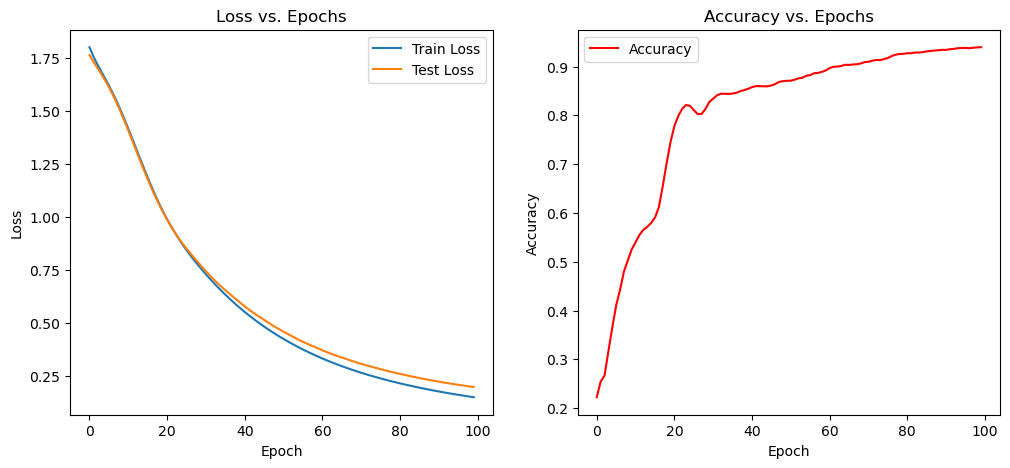

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label="Accuracy", color="r")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [18]:
print(f"Best accuracy: {max(accuracies)}")
print(f"Best test loss: {min(test_losses)}")

Best accuracy: 0.9395995928062436
Best test loss: 0.19761721789836884
